In [157]:
# Импорт необходимых библиотек
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import yaml

In [158]:
# Загрузка базы знаний из файла
with open('knowledge_base.yml', 'r') as file:
    knowledge_base = yaml.load(file, Loader=yaml.FullLoader)

In [159]:
# Функция для фаззификации
def fuzzify(value, term):
    x = np.linspace(0, 100, 100)
    mfx = fuzz.trimf(x, term)
    return fuzz.interp_membership(x, mfx, value)

In [160]:
# Функция для применения правил
def apply_rules(attributes, rules, knowledge_base):
    for rule in rules:
        if eval_condition(attributes, rule["antecedent"], knowledge_base):
            return rule["consequent"]
    return {"attribute": "credit", "value": 'rejected'}

In [161]:
# Функция для проверки условия в антецеденте
def eval_condition(attributes, condition, knowledge_base):
    output = []
    for sub_condition in condition:
        attr_name = sub_condition["attribute"]
        if attr_name in attributes:
            attr_value = attributes[attr_name]
            fuzzy_set = sub_condition.get("fuzzy_set")
            if fuzzy_set:
                membership = fuzzify(attr_value, knowledge_base["attributes"][attr_name]["fuzzy_sets"][fuzzy_set])
                if membership != 0:
                    output.append(True)
                    continue
            else:
                # Только для атрибута credit_history
                history = sub_condition.get("operator") == "eq" and attributes[attr_name] == 'good'
                output.append(history)
                continue
        else:
            output.append(False)
            continue

    if len(output) > 1 and all(output):
        return True
    else:
        return False

In [162]:
# Функция для визуализации
def visualize(users, rules, knowledge_base):
    approved_good = [user for user in users if apply_rules(user, rules, knowledge_base) is not None and apply_rules(user, rules, knowledge_base)["value"] == "approved" and user["credit_history"] == "good"]
    approved_bad = [user for user in users if apply_rules(user, rules, knowledge_base) is not None and apply_rules(user, rules, knowledge_base)["value"] == "approved" and user["credit_history"] == "bad"]
    rejected_good = [user for user in users if apply_rules(user, rules, knowledge_base) is not None and apply_rules(user, rules, knowledge_base)["value"] == "rejected" and user["credit_history"] == "good"]
    rejected_bad = [user for user in users if apply_rules(user, rules, knowledge_base) is not None and apply_rules(user, rules, knowledge_base)["value"] == "rejected" and user["credit_history"] == "bad"]

    fig, ax = plt.subplots()

    ax.scatter([user["age"] for user in approved_good], [user["income"] for user in approved_good], color='g', marker='o', label='Approved (Good Credit History)')
    ax.scatter([user["age"] for user in approved_bad], [user["income"] for user in approved_bad], color='g', marker='s', label='Approved (Bad Credit History)')
    ax.scatter([user["age"] for user in rejected_good], [user["income"] for user in rejected_good], color='r', marker='o', label='Rejected (Good Credit History)')
    ax.scatter([user["age"] for user in rejected_bad], [user["income"] for user in rejected_bad], color='r', marker='s', label='Rejected (Bad Credit History)')

    ax.set_title('Credit Approval')
    ax.set_xlabel('Age')
    ax.set_ylabel('Income')
    ax.legend(loc=4)

    plt.show()

In [163]:
def explain_decision(user, rules, knowledge_base):
    antecedent_values = []
    consequent_value = None

    # Проверяем каждое правило
    for rule in rules:
        # Проверяем условие для антецедента
        if eval_condition(user, rule['antecedent'], knowledge_base):
            antecedent_values.append(rule['antecedent'])
            consequent_value = rule['consequent']
            break

    explanation = {
        'user': user,
        'antecedent_values': antecedent_values,
        'consequent_value': consequent_value
    }

    return explanation

Решение для пользователя {'age': 20, 'income': 20000, 'credit_history': 'bad'}: {'user': {'age': 20, 'income': 20000, 'credit_history': 'bad'}, 'antecedent_values': [], 'consequent_value': None}
Решение для пользователя {'age': 15, 'income': 25000, 'credit_history': 'good'}: {'user': {'age': 15, 'income': 25000, 'credit_history': 'good'}, 'antecedent_values': [], 'consequent_value': None}
Решение для пользователя {'age': 30, 'income': 80000, 'credit_history': 'good'}: {'user': {'age': 30, 'income': 80000, 'credit_history': 'good'}, 'antecedent_values': [[{'attribute': 'age', 'fuzzy_set': 'middle_aged'}, {'attribute': 'income', 'fuzzy_set': 'medium'}, {'attribute': 'credit_history', 'operator': 'eq', 'value': 'good'}]], 'consequent_value': {'attribute': 'credit', 'value': 'approved'}}
Решение для пользователя {'age': 50, 'income': 50000, 'credit_history': 'good'}: {'user': {'age': 50, 'income': 50000, 'credit_history': 'good'}, 'antecedent_values': [[{'attribute': 'age', 'fuzzy_set': 'm

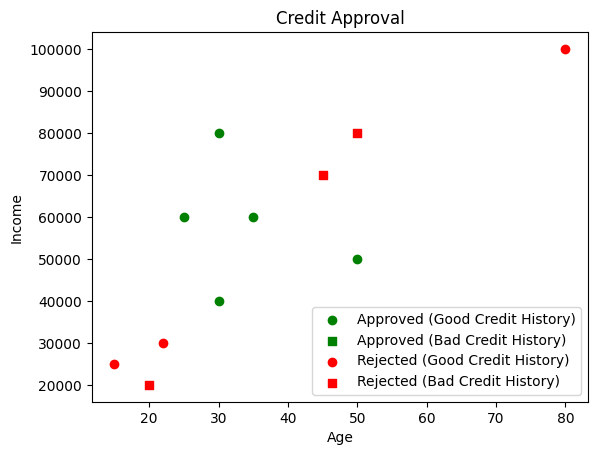

In [164]:
users = [
    {'age': 20, 'income': 20000, 'credit_history': 'bad'},
    {'age': 15, 'income': 25000, 'credit_history': 'good'},
    {'age': 30, 'income': 80000, 'credit_history': 'good'},
    {'age': 50, 'income': 50000, 'credit_history': 'good'},
    {'age': 35, 'income': 60000, 'credit_history': 'good'},
    {'age': 22, 'income': 30000, 'credit_history': 'good'},
    {'age': 80, 'income': 100000, 'credit_history': 'good'},
    {'age': 50, 'income': 80000, 'credit_history': 'bad'},
    {'age': 30, 'income': 40000, 'credit_history': 'good'},
    {'age': 25, 'income': 60000, 'credit_history': 'good'},
    {'age': 45, 'income': 70000, 'credit_history': 'bad'},
]
rules = knowledge_base['rules']

# Для каждого пользователя рисуем график
for user in users:
    result = apply_rules(user, rules, knowledge_base)
    explanation = explain_decision(user, rules, knowledge_base)
    print(f"Решение для пользователя {user}: {explanation}")


visualize(users, rules, knowledge_base)